Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Covariance matrix shape:  torch.Size([1916232, 3, 3])
Number of gaussian splats:  1916232
Mean Covaraince of x:  0.003068927675485611
Mean Covaraince of y:  0.002929619513452053
Mean Covaraince of z:  0.0030834514182060957


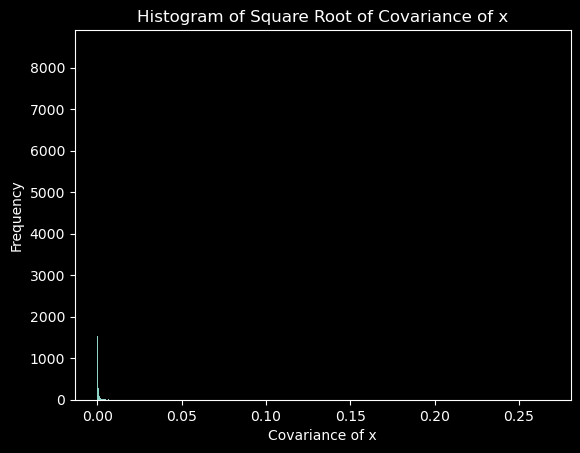

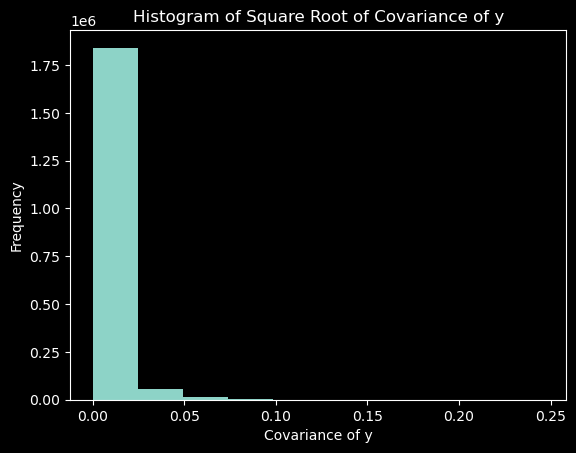

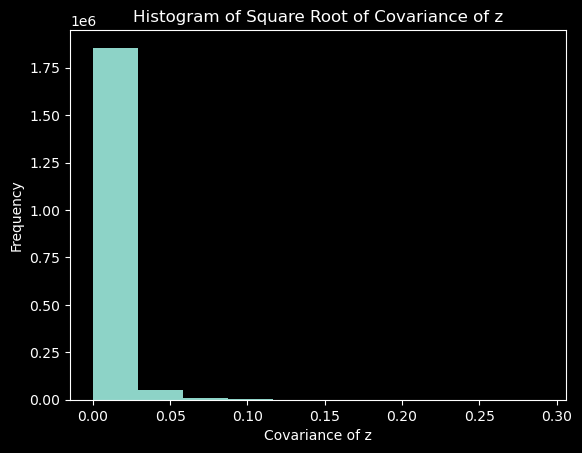

In [2]:
# %%
# env : conda('base')
import open3d as o3d
import numpy as np
from plyfile import PlyData, PlyElement
import torch
from torch import nn
import matplotlib.pyplot as plt


def load_ply(path):
    max_sh_degree = 3
    
    plydata = PlyData.read(path)

    xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                    np.asarray(plydata.elements[0]["y"]),
                    np.asarray(plydata.elements[0]["z"])),  axis=1)
    opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

    features_dc = np.zeros((xyz.shape[0], 3, 1))
    features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
    features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
    features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

    extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
    extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
    assert len(extra_f_names)==3*(max_sh_degree + 1) ** 2 - 3
    features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
    for idx, attr_name in enumerate(extra_f_names):
        features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
    # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
    features_extra = features_extra.reshape((features_extra.shape[0], 3, (max_sh_degree + 1) ** 2 - 1))

    scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
    scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
    scales = np.zeros((xyz.shape[0], len(scale_names)))
    for idx, attr_name in enumerate(scale_names):
        scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

    rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
    rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
    rots = np.zeros((xyz.shape[0], len(rot_names)))
    for idx, attr_name in enumerate(rot_names):
        rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

    return xyz, features_dc, features_extra, opacities, scales, rots

# %%
path = '/mnt/sda/home/cvlab03/project/3dgs/gaussian-splatting/output/baseline/point_cloud/iteration_7000/point_cloud.ply'
xyz, features_dc, features_extra, opacities, scales, rots = load_ply(path)

# %%
def build_rotation(r):
    norm = torch.sqrt(r[:,0]*r[:,0] + r[:,1]*r[:,1] + r[:,2]*r[:,2] + r[:,3]*r[:,3])

    q = r / norm[:, None]

    R = torch.zeros((q.size(0), 3, 3), device='cuda')

    r = q[:, 0]
    x = q[:, 1]
    y = q[:, 2]
    z = q[:, 3]

    R[:, 0, 0] = 1 - 2 * (y*y + z*z)
    R[:, 0, 1] = 2 * (x*y - r*z)
    R[:, 0, 2] = 2 * (x*z + r*y)
    R[:, 1, 0] = 2 * (x*y + r*z)
    R[:, 1, 1] = 1 - 2 * (x*x + z*z)
    R[:, 1, 2] = 2 * (y*z - r*x)
    R[:, 2, 0] = 2 * (x*z - r*y)
    R[:, 2, 1] = 2 * (y*z + r*x)
    R[:, 2, 2] = 1 - 2 * (x*x + y*y)
    return R

def build_scaling_rotation(s, r):
    s = torch.Tensor(s)
    r = torch.Tensor(r)
    
    L = torch.zeros((s.shape[0], 3, 3), dtype=torch.float, device="cuda")
    R = build_rotation(r)

    L[:,0,0] = s[:,0]
    L[:,1,1] = s[:,1]
    L[:,2,2] = s[:,2]

    L = R @ L
    return L

def build_3dcov(s, r):
    L = build_scaling_rotation(s, r)
    return L @ L.transpose(1,2)

# %%
scales = torch.Tensor(scales)
rots = torch.Tensor(rots)
cov = build_3dcov(torch.exp(scales), torch.nn.functional.normalize(rots))
print('Covariance matrix shape: ', cov.shape)

# %%
# Scne : Bicycle
# Iter : 30000
mean_cov_x = (torch.mean((cov[:, 0, 0])))
mean_cov_y = (torch.mean((cov[:, 1, 1])))
mean_cov_z = (torch.mean((cov[:, 2, 2])))

print('Number of gaussian splats: ', cov.shape[0])
print('Mean Covaraince of x: ', mean_cov_x.item())
print('Mean Covaraince of y: ', mean_cov_y.item())
print('Mean Covaraince of z: ', mean_cov_z.item())

# %%
# Histogram of square root of x covariance
plt.hist((cov[:, 0, 0].cpu().numpy()), bins='auto', density=True)
plt.xlabel('Covariance of x')
plt.ylabel('Frequency')
plt.title('Histogram of Square Root of Covariance of x')
plt.show()

# Histogram of square root of y covariance
plt.hist((cov[:, 1, 1].cpu().numpy()), bins=10)
plt.xlabel('Covariance of y')
plt.ylabel('Frequency')
plt.title('Histogram of Square Root of Covariance of y')
plt.show()

# Histogram of square root of z covariance
plt.hist((cov[:, 2, 2].cpu().numpy()), bins=10)
plt.xlabel('Covariance of z')
plt.ylabel('Frequency')
plt.title('Histogram of Square Root of Covariance of z')
plt.show()

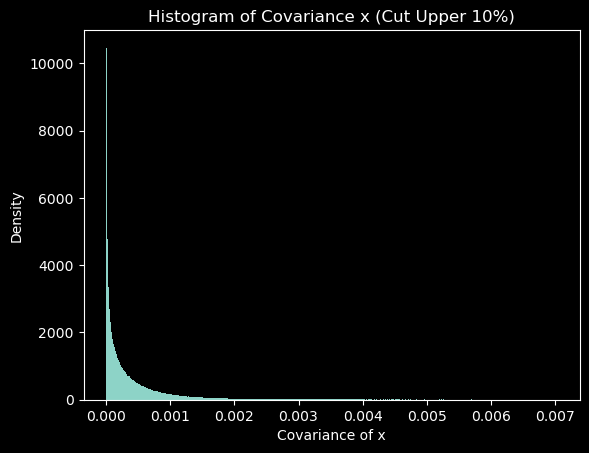

In [9]:
cov_x = cov[:, 0, 0]
# Cut Upper 10% of the covariance
cov_x = cov_x[cov_x < torch.quantile(cov_x, 0.9)]
# Histogram of square root of x covariance
plt.hist((cov_x.cpu().numpy()), bins='auto', density=True)
plt.xlabel('Covariance of x')
plt.ylabel('Density')
plt.title('Histogram of Covariance x (Cut Upper 10%)')
plt.show()

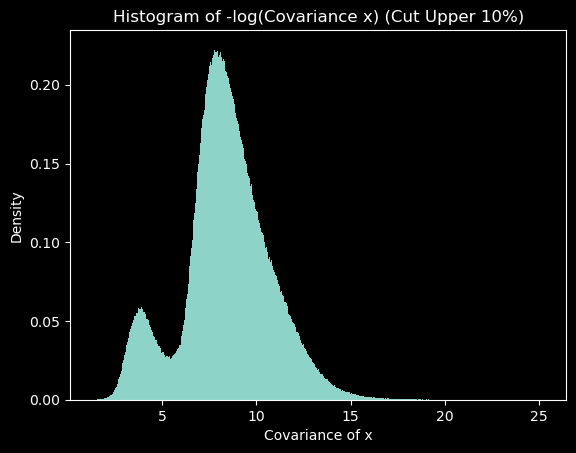

In [10]:
cov_x = cov[:, 0, 0]
# Cut Upper 10% of the covariance
# cov_x = cov_x[cov_x < torch.quantile(cov_x, 0.9)]
# Histogram of square root of x covariance
plt.hist(-np.log(cov_x.cpu().numpy()), bins='auto', density=True)
plt.xlabel('Covariance of x')
plt.ylabel('Density')
plt.title('Histogram of -log(Covariance x) (Cut Upper 10%)')
plt.show()